test<h1 align="center">ПРОГНОЗИРОВАНИЕ НАГРУЗКИ ОФИСНЫХ ЗДАНИЙ ДЛЯ ПОВЫШЕНИЯ ЭФФЕКТИВНОСТИ СИСТЕМ УПРАВЛЕНИЯ ЭНЕРГОПОТРЕБЛЕНИЕМ В УСЛОВИЯХ ПАНДЕМИИ COVID-19</h1>

### Проблема: <br>
В связи с пандемией COVID-19, переход ряда сотрудников на удаленную работу приобрел стохастический характер, что требует совершенствования используемых подходов к прогнозированию потребления электрической энергии. В связи с этим представляется целесообразным учет дополнительных параметров для прогнозирования.

В рамках задания необходимо подготовить модель машинного обучения, обеспечивающую высокую точность прогнозирования нагрузки офисного здания в условиях пандемии COVID-19.

<span style='color:crimson'> *Разведочный анализ приведен в ноутбуке RTSoft.ipynb, на основе которого в данному ноутбуке рассматривается построение и обучение модели для указанной задачи </span>

### Загрузка библиотек

In [1]:
# data processing and analysis
import os
import pickle
import numpy as np
import pandas as pd
from copy import deepcopy
from itertools import compress
# import statsmodels.api as sm
import datetime

# module with information about holidays
import holidays

# filtering warnings
import warnings
warnings.filterwarnings('ignore')

# drawing
import matplotlib.pyplot as plt
import seaborn as sns

# data markup
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

# metrics
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score

# models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

# color scheme
sns.set(color_codes=True)

### Загрузка и обработка данных

In [41]:
# files path's
icp_url = os.path.join(os.getcwd(), 'data', 'building_data.xlsx')
icp_features_url = os.path.join(os.getcwd(),'data', 'building_features.pickle')

metering_device_url = os.path.join(os.getcwd(), 'data', 'building_data_meters.xlsx')
metering_features_url = os.path.join(os.getcwd(), 'data', 'meter_features.pickle')

svo_wheather_url = os.path.join(os.getcwd(), 'data', 'SVO.xls')
vdnh_wheather_url = os.path.join(os.getcwd(), 'data', 'VDNH.xls')

covid_url = os.path.join(os.getcwd(), 'data', 'covid.xlsx')

isolation_url = os.path.join(os.getcwd(), 'data', 'isolation.xlsx')

In [3]:
# data preprocessing
def icp_preprocess(data_url, selected_features_url):
    '''
    ICP DAS data preprocessing
    '''
    # load data
    df = pd.read_excel(data_url)
    # local time shift - UTC+3
    df['time'] = df['time'] + pd.DateOffset(hours=3)
    # target column
    df['target'] = (df['_Bus_1_p_TM1H_mv_val'] + df['_Bus_2_p_TM1H_mv_val'] + 
                    df['_Bus_3_p_TM1H_mv_val'] + df['_Bus_4_p_TM1H_mv_val'])
    
    with open(selected_features_url, 'rb') as fp:
        # load list of features
        columns = pickle.load(fp)
    
    # keep selected features
    df = df[['time', 'target'] + columns]

    # sorting by time
    df = df.sort_values(by='time', ascending=True).set_index('time')

    return df

In [121]:
def meter_preprocess(data_url, selected_features_url):
    '''
    metering devices data preprocessing
    '''
    # load data
    df = pd.read_excel(data_url)
    # local time shift - UTC+3
    df['time'] = df['time'] + pd.DateOffset(hours=3)
    
    with open(selected_features_url, 'rb') as fp:
        # load list of features
        columns = pickle.load(fp)
    
    # keep selected features
    df = df[['time'] + columns]
    
    # average data by hour
    df = df.set_index('time').resample('H').mean()
    df.reset_index(drop=True)
    
    def remove_anomaly(df):
        '''
        remove anomalies
        '''
        for i in range(1,5):
            median = df[f'_electricityMeter_{i}_p_T30M_mv_val'].median()
            df[f'_electricityMeter_{i}_p_T30M_mv_val'] = df.apply(lambda row: median if row[f'_electricityMeter_{i}_p_T30M_mv_val']>500 else
                                                                    row[f'_electricityMeter_{i}_p_T30M_mv_val'], axis=1)
        return df
    
    return remove_anomaly(df)

In [5]:
def svo_preprocess(data_url, selected_features_url):
    '''
    wheather data preprocessing
    '''
    df = pd.read_excel(data_url, header=6)
    # rename time column and convert to datetime format
    df = df.rename(columns={'Местное время в Шереметьево / им. А. С. Пушкина (аэропорт)': 'time'})
    df['time'] = pd.to_datetime(df['time'])
    # split cloudness variable into to subparameters
    df['c_1'] = df['c'].str.extract('(\d+)\s\w')
    df['c_2'] = df['c'].str.extract('([\w\s]+)')
    # comnbine data on cloudness
    df['c'] = df.apply(lambda row: 0 if row['c_2']=='Нет существенной облачности' else float(row['c_1']), axis=1)
    # convert temperature into Kelvins to get rid of negative values
    df['T'] = df['T'] + 273.15
    
    #### keep only temperature, atmospheric pressure and cloudness columns in selected features ###
    
    df = df[['time'] + selected_features_url]
    
    return df

In [6]:
def vdnh_preprocess(data_url):
    '''
    wheather data preprocessing (get precipitation)
    '''
    df = pd.read_excel(data_url, header=6)
    # rename time column and convert to datetime format
    df = df.rename(columns={'Местное время в Москве (ВДНХ)': 'time'})
    df['time'] = pd.to_datetime(df['time'])
    # comnbine data on cloudness
    df['precipitation'] = df.apply(lambda row: 0 if (row['RRR']=='Следы осадков' or 
                                                         row['RRR']=='Осадков нет')
                                       else float(row['RRR']), axis=1)

    df['precipitation'] = df['precipitation'].fillna(0)

    df = df[['time', 'precipitation']]
    
    return df

In [7]:
def covid_preprocessing(data_url):
    '''
    covid data preprocessing
    '''
    df = pd.read_excel(data_url, header=None)
    # convert to datetime
    df[0] = pd.to_datetime(df[0])
    df = df.rename(columns={0:'time', 1:'covid_cases'})
    
    return df

In [61]:
def isolation_preprocessing(data_url):
    '''
    isolation index preprocessing
    '''
    df = pd.read_excel(data_url, header=0)
    df = df.rename(columns={'DateTime':'time', 'Индекс':'isolation_idx'})
    # convert to datetime
    df['time'] = pd.to_datetime(df['time'])
    
    return df

#### Препроцессинг

In [122]:
# preprocessed data

# relevant icp_das features
icp_das = icp_preprocess(icp_url, icp_features_url)
# relevant metering devices features
meter_dev = meter_preprocess(metering_device_url, metering_features_url)
# temperature, atmospheric pressure, cloudness
svo = svo_preprocess(svo_wheather_url, ['T', 'U', 'c'])
# precipitation
vdnh = vdnh_preprocess(vdnh_wheather_url)
# covid cases
covid = covid_preprocessing(covid_url)

In [123]:
# isolation index
isolation = isolation_preprocessing(isolation_url)

In [124]:
def merge_data(*args):
    '''
    merging datasets
    '''
    data = args[0]
    for i in range(1, len(args)):
        data = data.merge(args[i], how='left', on='time')
    
    return data

In [125]:
data = merge_data(icp_das, meter_dev, svo, vdnh, covid, isolation)

In [126]:
data = data.set_index('time')
# populating daily values
data['covid_cases'] = data['covid_cases'].groupby(pd.Grouper(freq='D')).ffill()
data['isolation_idx'] = data['isolation_idx'].groupby(pd.Grouper(freq='D')).ffill()

In [127]:
# fill leaking values
data.loc[:'2020-03','covid_cases'] = data.loc[:'2020-03', 'covid_cases'].fillna(0)
data.loc[:'2020-03','isolation_idx'] = data.loc[:'2020-03', 'isolation_idx'].fillna(0)

In [128]:
# save preprocessed data to file
def save_to_file(data, name):
    data.to_csv(os.path.join(os.getcwd(), 'data', f'{name}.csv'))
    
# save_to_file(data, 'final')
# data = pd.read_csv(os.path.join(os.getcwd(), 'data','final.csv'))

### Построение модели

#### Метрики

In [129]:
# MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [130]:
# RMSE
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score

rmse_score = metrics.make_scorer(rmse, greater_is_better = False)

In [131]:
# print metrics
def regression_results(y_true, y_pred):
    metric = [metrics.explained_variance_score(y_true, y_pred),
              metrics.mean_absolute_error(y_true, y_pred),
              metrics.mean_squared_error(y_true, y_pred),
              metrics.mean_squared_log_error(y_true, y_pred),
              mean_absolute_percentage_error(y_true, y_pred),
              metrics.r2_score(y_true, y_pred),
              rmse(y_true, y_pred)
               ]
    ind = ['explained_variance', 'MAE', 'MSE', 'mean_squared_log_error', 'MAPE', 'r2',  'RMSE']
    
    round_metrics = [round(x, 4) for x in metric]
    
    return pd.DataFrame(data=round_metrics, index=ind, columns=['metrics'])

#### Feature engineering

In [132]:
# copy data
df = deepcopy(data)
# specify data frequency wtith impiting based on nearest neighbours
test = df.asfreq('H', method = 'ffill')

In [133]:
# add weekday
test['weekday'] = test.index.weekday

In [134]:
# add yearday
test['yearday'] = test.index.dayofyear

In [135]:
# add monthday
test['monthday'] = test.index.to_series().dt.day

In [136]:
# add month
test['month'] = test.index.month

In [137]:
# add holidays
rus_holidays = holidays.Russia()

def holidays_selector(df, holidays_list):
    res = []
    for t in df.index:
        if t in holidays_list:
            res.append(1)
        else:
            res.append(0)
    return pd.DataFrame({'time': df.index,  'holiday':res})

all_holidays = holidays_selector(test, rus_holidays)

In [138]:
# lockdown regime
# set time of lockdown in Moscow
lockdown = pd.DataFrame(pd.date_range(start='2020-03-30 00:00',end='2020-06-08 23:00', freq='H'), columns=['time'])
# set corresponding column to 1
lockdown['lockdown'] = 1

In [139]:
# add lockdown period
test = merge_data(test, all_holidays, lockdown).set_index('time')

In [140]:
# fill NAs
test['lockdown'] = test['lockdown'].fillna(0)
test['precipitation'] = test['precipitation'].fillna(0)

In [141]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22824 entries, 2018-03-16 16:00:00 to 2020-10-22 15:00:00
Data columns (total 39 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   target                                    22523 non-null  float64
 1   _Consumers_Bus_2_p_TM1H_mv_val            22633 non-null  float64
 2   _externalGrid_Bus_1_phaseA_p_TM1H_mv_val  11376 non-null  float64
 3   _externalGrid_Bus_1_phaseB_p_TM1H_mv_val  11376 non-null  float64
 4   _externalGrid_Bus_1_phaseC_p_TM1H_mv_val  11376 non-null  float64
 5   _externalGrid_Bus_2_phaseA_p_TM1H_mv_val  11376 non-null  float64
 6   _externalGrid_Bus_2_phaseB_p_TM1H_mv_val  11376 non-null  float64
 7   _externalGrid_Bus_2_phaseC_p_TM1H_mv_val  11376 non-null  float64
 8   _unctrl_load_Bus_1_p_TM1H_mv_val          11376 non-null  float64
 9   _unctrl_load_Bus_1_phaseA_p_TM1H_mv_val   11376 non-null  float64
 10 

In [150]:
from sklearn.impute import KNNImputer
# impute missing values using KNN method
imputer = KNNImputer()
test_trans = imputer.fit_transform(test)

In [153]:
df_imputed = pd.DataFrame(data = test_trans, columns = test.columns)

In [155]:
df_imputed['time'] = test.index
df_imputed = df_imputed.set_index('time')

In [156]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22824 entries, 2018-03-16 16:00:00 to 2020-10-22 15:00:00
Data columns (total 39 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   target                                    22824 non-null  float64
 1   _Consumers_Bus_2_p_TM1H_mv_val            22824 non-null  float64
 2   _externalGrid_Bus_1_phaseA_p_TM1H_mv_val  22824 non-null  float64
 3   _externalGrid_Bus_1_phaseB_p_TM1H_mv_val  22824 non-null  float64
 4   _externalGrid_Bus_1_phaseC_p_TM1H_mv_val  22824 non-null  float64
 5   _externalGrid_Bus_2_phaseA_p_TM1H_mv_val  22824 non-null  float64
 6   _externalGrid_Bus_2_phaseB_p_TM1H_mv_val  22824 non-null  float64
 7   _externalGrid_Bus_2_phaseC_p_TM1H_mv_val  22824 non-null  float64
 8   _unctrl_load_Bus_1_p_TM1H_mv_val          22824 non-null  float64
 9   _unctrl_load_Bus_1_phaseA_p_TM1H_mv_val   22824 non-null  float64
 10 

In [161]:
# all data day shift
df_imputed.iloc[:, 1:] = df_imputed.iloc[:, 1:].shift(24)

In [163]:
# remove NAs
df_imputed = df_imputed.dropna()

In [257]:
# all data day shift
df_ = deepcopy(test)
df_.iloc[:, 1:] = df_.iloc[:, 1:].shift(24)

In [258]:
# remove NAs
df_not_imputed = df_.dropna()

In [164]:
print(f'Временной интервал - c {test.index.min()} по {test.index.max()}')

Временной интервал - c 2018-03-16 16:00:00 по 2020-10-22 15:00:00


In [378]:
# remove uncomplete data days
test = test['2019-07-08':'2020-10-21']

In [259]:
 # number of months between two dates
((df_not_imputed.index[-1] - df_not_imputed.index[0])/np.timedelta64(1, 'M'))

15.538991218163275

In [172]:
tscv = TimeSeriesSplit(n_splits=15)

#### Тренировочный и тестовый датасеты

In [260]:
# splitting into train and test datasets
X_train = df_not_imputed[:'2020-10-20'].drop(['target'], axis = 1)
y_train = df_not_imputed.loc[:'2020-10-20', 'target']

X_test = df_not_imputed['2020-10-21':].drop(['target'], axis = 1)
y_test = df_not_imputed.loc['2020-10-21':, 'target']

In [265]:
# splitting week
X_train = df_not_imputed[:'2020-10-4'].drop(['target'], axis = 1)
y_train = df_not_imputed.loc[:'2020-10-4', 'target']

X_test = df_not_imputed['2020-10-05':'2020-10-09'].drop(['target'], axis = 1)
y_test = df_not_imputed.loc['2020-10-05':'2020-10-09':, 'target']

#### Модели

In [180]:
# select parameters for GBR
gbr = GradientBoostingRegressor(random_state=0)
gbr_param_search = { 
    'n_estimators': [200, 300, 400, 500],
    'max_features': ['auto'],
    'max_depth' : [i for i in range(3,7)]
}

gbr_gsearch = GridSearchCV(estimator=gbr, cv=tscv, param_grid=gbr_param_search, scoring = rmse_score)
gbr_gsearch.fit(X_train, y_train)
print(gbr_gsearch.best_params_)

{'max_depth': 5, 'max_features': 'auto', 'n_estimators': 30}


In [173]:
# select parameters for XGB
xgb = XGBRegressor(random_state=0)
xgb_param_search = { 
    'n_estimators': [200, 300, 400, 500],
    'max_features': ['auto'],
    'max_depth' : [i for i in range(3,7)]
}

xgb_gsearch = GridSearchCV(estimator=xgb, cv=tscv, param_grid=xgb_param_search, scoring = rmse_score)
xgb_gsearch.fit(X_train, y_train)
print(xgb_gsearch.best_params_)

{'max_depth': 4, 'max_features': 'auto', 'n_estimators': 10}


In [272]:
GBR_model = GradientBoostingRegressor(max_depth = 5, max_features = 'auto', n_estimators = 30, random_state=0).fit(X_train, y_train)
XGB_model = XGBRegressor(max_depth = 5, max_features = 'auto', n_estimators = 10, random_state=0).fit(X_train, y_train)
y_pred_x = XGB_model.predict(X_test)
y_pred_g = GBR_model.predict(X_test)
y_true = y_test.values

In [181]:
y_pred_x = xgb_gsearch.best_estimator_.predict(X_test)
y_pred_g = gbr_gsearch.best_estimator_.predict(X_test)

In [273]:
y_pred = (y_pred_x + y_pred_g)/2

In [274]:
regression_results(y_true, y_pred)

,metrics
explained_variance,0.9620
MAE,4.1480
MSE,31.3598
mean_squared_log_error,0.0035
MAPE,4.5856
r2,0.9578
RMSE,5.6000


In [275]:
res = pd.DataFrame({'time':X_test.index, 'pred':y_pred, 'true':y_true})
res = res.set_index('time')
daytime = res.between_time('7:00', '22:00')
regression_results(daytime['true'], daytime['pred'])

,metrics
explained_variance,0.9275
MAE,5.5780
MSE,45.7461
mean_squared_log_error,0.0050
MAPE,5.7982
r2,0.9190
RMSE,6.7636


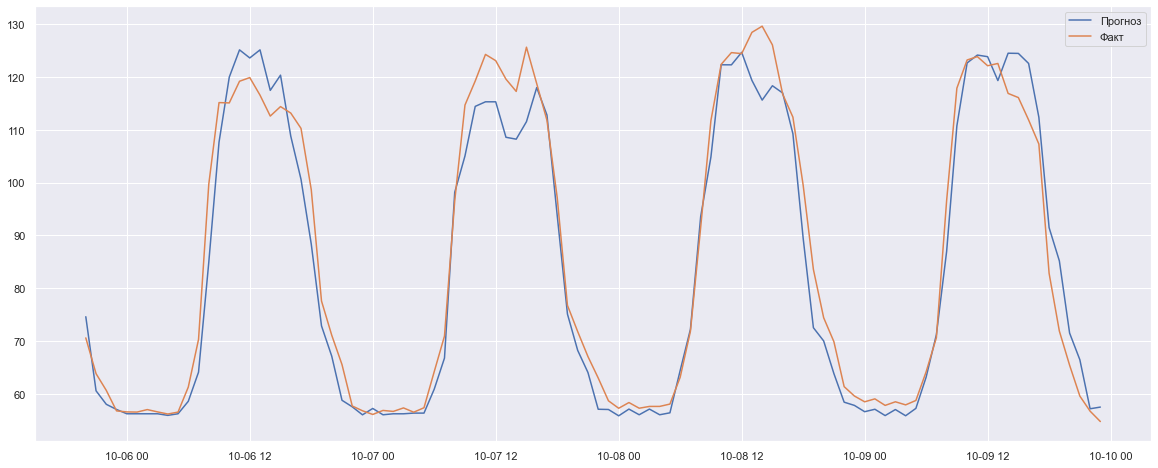

In [276]:
fig, ax = plt.subplots(figsize=(20,8))

ax.plot(res.index, res['pred'], label='Прогноз')
ax.plot(res.index, res['true'], label='Факт')

plt.legend(loc='upper right')

plt.show()

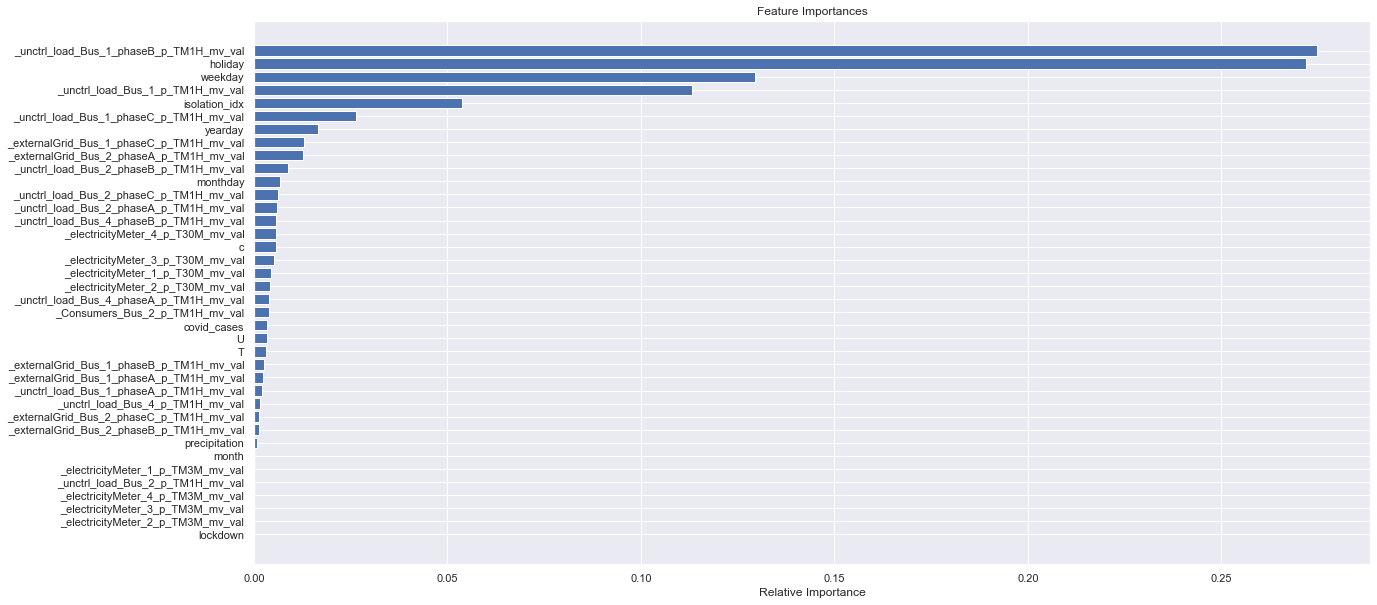

In [271]:
imp = XGB_model.feature_importances_
plt.figure(figsize=(20,10))
features = X_train.columns
indices = np.argsort(imp)
plt.title('Feature Importances')
plt.barh(range(len(indices)), imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()